In [76]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from PIL import Image
import glob
from pickle import dump, load
import pickle
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image as kimage
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

In [86]:
class ImageTextAdequacy(object):
    
    def __init__(self):
        self.captions = "E://TFM/Flickr8k/captions.txt"
        self.images = 'E://TFM/Flickr8k/Images/'
        self.glove_dir = 'E://TFM/Glove/glove.6B.200d.txt'
        self.embedding_dim = 200
    
    # load doc into memory
    def load_doc(self, filename):
        # open the file as read only
        file = open(filename, 'r')
        # read all text
        text = file.read()
        # close the file
        file.close()
        return text
    
    def load_descriptions(self, doc):
        mapping = dict()
        # process lines
        for line in doc.split('\n'):
            # split line by white space
            tokens = line.split()
            if len(line) < 2:
                continue
            # take the first token as the image id, the rest as the description
            image_id, image_desc = tokens[0], tokens[1:]
            # extract filename from image id
            image_id = image_id.split('.')[0]
            # convert description tokens back to string
            image_desc = ' '.join(image_desc)
            # create the list if needed
            if image_id not in mapping:
                mapping[image_id] = list()
            # store description
            mapping[image_id].append(image_desc)
        return mapping
    
    def clean_descriptions(self, descriptions):
        # prepare translation table for removing punctuation
        table = str.maketrans('', '', string.punctuation)
        for key, desc_list in descriptions.items():
            for i in range(len(desc_list)):
                desc = desc_list[i]
                # tokenize
                desc = desc.split()
                # convert to lower case
                desc = [word.lower() for word in desc]
                # remove punctuation from each token
                desc = [w.translate(table) for w in desc]
                # remove hanging 's' and 'a'
                desc = [word for word in desc if len(word)>1]
                # remove tokens with numbers in them
                desc = [word for word in desc if word.isalpha()]
                # store as string
                desc_list[i] =  ' '.join(desc)
                
    # convert the loaded descriptions into a vocabulary of words
    def to_vocabulary(self, descriptions):
        # build a list of all description strings
        all_desc = set()
        for key in descriptions.keys():
            [all_desc.update(d.split()) for d in descriptions[key]]
        return all_desc
    
    # save descriptions to file, one per line
    def save_descriptions(self, descriptions, filename):
        lines = list()
        for key, desc_list in descriptions.items():
            for desc in desc_list:
                lines.append(key + ' ' + desc)
        data = '\n'.join(lines)
        file = open(filename, 'w')
        file.write(data)
        file.close()
        
    # load a pre-defined list of photo identifiers
    def load_set(self, filename):
        doc = load_doc(filename)
        dataset = list()
        # process line by line
        for line in doc.split('\n'):
            # skip empty lines
            if len(line) < 1:
                continue
            # get the image identifier
            identifier = line.split('.')[0]
            dataset.append(identifier)
        return set(dataset)

    # load clean descriptions into memory
    def load_clean_descriptions(self, filename, dataset):
        # load document
        doc = load_doc(filename)
        descriptions = dict()
        for line in doc.split('\n'):
            # split line by white space
            tokens = line.split()
            # split id from description
            image_id, image_desc = tokens[0], tokens[1:]
            # skip images not in the set
            if image_id in dataset:
                # create list
                if image_id not in descriptions:
                    descriptions[image_id] = list()
                # wrap description in tokens
                desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
                # store
                descriptions[image_id].append(desc)
        return descriptions

    def preprocess(self, image_path):
        # Convert all the images to size 299x299 as expected by the inception v3 model
        img = kimage.load_img(image_path, target_size=(299, 299))
        # Convert PIL image to numpy array of 3-dimensions
        x = kimage.img_to_array(img)
        # Add one more dimension
        x = np.expand_dims(x, axis=0)
        # preprocess the images using preprocess_input() from inception module
        x = preprocess_input(x)
        return x
    
    # Function to encode a given image into a vector of size (2048, )
    def encode(self, image, model_new):
        image = self.preprocess(image) # preprocess the image
        fea_vec = model_new.predict(image) # Get the encoding vector for the image
        fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
        return fea_vec
    
    # convert a dictionary of clean descriptions to a list of descriptions
    def to_lines(self, descriptions):
        all_desc = list()
        for key in descriptions.keys():
            [all_desc.append(d) for d in descriptions[key]]
        return all_desc

    # calculate the length of the description with the most words
    def max_length(self, descriptions):
        lines = to_lines(descriptions)
        return max(len(d.split()) for d in lines)
    
    # data generator, intended to be used in a call to model.fit_generator()
    def data_generator(self, descriptions, photos, wordtoix, max_length, num_photos_per_batch):
        X1, X2, y = list(), list(), list()
        n=0
        # loop for ever over images
        while 1:
            for key, desc_list in descriptions.items():
                print(key.__class__)
                n+=1
                # retrieve the photo feature
                photo = photos[key+'.jpg']
                for desc in desc_list:
                    # encode the sequence
                    seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                    # split one sequence into multiple X, y pairs
                    for i in range(1, len(seq)):
                        # split into input and output pair
                        in_seq, out_seq = seq[:i], seq[i]
                        # pad input sequence
                        in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                        # encode output sequence
                        out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                        # store
                        X1.append(photo)
                        X2.append(in_seq)
                        y.append(out_seq)
                # yield the batch data
                if n==num_photos_per_batch:
                    yield [array(X1), array(X2)], array(y)
                    X1, X2, y = list(), list(), list()
                    n=0
                    
    def greedySearch(self, photo):
        in_text = 'startseq'
        for i in range(max_length):
            sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
            sequence = pad_sequences([sequence], maxlen=max_length)
            yhat = model.predict([photo,sequence], verbose=0)
            yhat = np.argmax(yhat)
            word = ixtoword[yhat]
            in_text += ' ' + word
            if word == 'endseq':
                break
        final = in_text.split()
        final = final[1:-1]
        final = ' '.join(final)
        return final
        
    def caption_image(self, image_path):
        
        # descriptions
        train_descriptions = load_clean_descriptions('descriptions.txt', train)
        
        # Load the inception v3 model
        model = InceptionV3(weights='imagenet')
        
        # Create a new model, by removing the last layer (output layer) from the inception v3
        model_new = Model(model.input, model.layers[-2].output)
        
        # Create a list of all the training captions
        all_train_captions = []
        for key, val in train_descriptions.items():
            for cap in val:
                all_train_captions.append(cap)
                
        # Consider only words which occur at least 10 times in the corpus
        word_count_threshold = 10
        word_counts = {}
        nsents = 0
        for sent in all_train_captions:
            nsents += 1
            for w in sent.split(' '):
                word_counts[w] = word_counts.get(w, 0) + 1

        vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
        
        ixtoword = {}
        wordtoix = {}

        ix = 1
        for w in vocab:
            wordtoix[w] = ix
            ixtoword[ix] = w
            ix += 1
            
        vocab_size = len(ixtoword) + 1 # one for appended 0's
        
        # determine the maximum sequence length
        max_length = self.max_length(train_descriptions)
        
        # Load Glove vectors
        embeddings_index = {} # empty dictionary
        f = open(self.glove_dir, encoding="utf-8")

        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
        f.close()
        
        # Get 200-dim dense vector for each of the 10000 words in out vocabulary
        embedding_matrix = np.zeros((vocab_size, embedding_dim))

        for word, i in wordtoix.items():
            #if i < max_words:
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                # Words not found in the embedding index will be all zeros
                embedding_matrix[i] = embedding_vector
                
        inputs1 = Input(shape=(2048,))
        fe1 = Dropout(0.5)(inputs1)
        fe2 = Dense(256, activation='relu')(fe1)
        inputs2 = Input(shape=(max_length,))
        se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
        se2 = Dropout(0.5)(se1)
        se3 = LSTM(256)(se2)
        decoder1 = add([fe2, se3])
        decoder2 = Dense(256, activation='relu')(decoder1)
        outputs = Dense(vocab_size, activation='softmax')(decoder2)
        model = Model(inputs=[inputs1, inputs2], outputs=outputs)
        
        model.layers[2].set_weights([embedding_matrix])
        model.layers[2].trainable = False
        
        model.load_weights('./model_weights/model_30.h5')
            
        x=plt.imread(image_path)
        encoded_img = self.encode(image_path, model_new).reshape((1,2048))
        plt.imshow(x)
        plt.show()
        print("Greedy:",greedySearch(encoded_img))

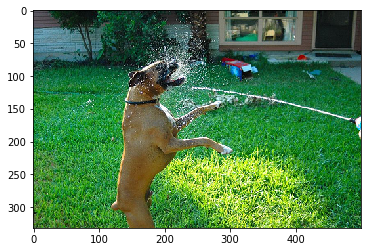

Greedy: brown dog is jumping up to catch ball


In [87]:
ita = ImageTextAdequacy()
ita.caption_image("E://TFM/Flickr8k/Images/44856031_0d82c2c7d1.jpg")